In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path

import psana as ps

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

## Runs informations

Run 60-63: 500eV with various attenuations

Run 64-79: 750eV with various attenuations

Run 80-94: 1000eV with various attenuations

Run 95-110: 1500eV with various attenuations

## EPICS information:

Attenuations: GATT:FEE1:310:R_ACT

GMD waveforms: GMD_ACQ_RAW

In [3]:
exp_name = 'sxr12416'
run = 60

save_path = Path('/reg/d/psdm/sxr/sxr12416/results/vesp')

In [4]:
dstr = 'exp={}:run={}'.format(exp_name, run) # do not take smd to access raw GMD waveforms
print('\n'+dstr+'\n')
# ds = ps.DataSource(dstr)
ds = ps.MPIDataSource(dstr)
ds.detnames()
# ds.detnames('epics')


exp=sxr12416:run=60



[('SxrEndstation.0:Acqiris.1', 'Acq01', ''),
 ('NoDetector.0:Evr.0', 'evr0', ''),
 ('EBeam', '', ''),
 ('PhaseCavity', '', ''),
 ('FEEGasDetEnergy', '', ''),
 ('GMD', '', ''),
 ('SXR-AIN-01', '', ''),
 ('NoDetector.0:Evr.1', 'evr1', ''),
 ('SxrEndstation.0:USDUSB.0', 'MONO_encoder', ''),
 ('ControlData', '', '')]

In [5]:
for det in ds.detnames('epics'):
    if 'GMD_ACQ_RAW' in det[1]:
        print('Found det {}'.format(det))
    if 'GATT:FEE1:310:R_ACT' in det[0]:
        print('Found det {}'.format(det))
    if 'SIOC:SYS0:ML00:AO541' in det[1]:
        print('Found det {}'.format(det))

Found det ('GATT:FEE1:310:R_ACT', '', '')
Found det ('SXR:GMD:ACQ:01:CH1:Data', 'GMD_ACQ_RAW', '')


In [6]:
def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)
    
# runs = np.arange(60,64)
# runs = np.arange(64,80)
# runs = np.arange(80,95)
# runs = np.arange(95,111)
runs = np.arange(60,111)

In [7]:
gmd = ps.Detector('GMD_ACQ_RAW')
ebeam = ps.Detector('EBeam')
att = ps.Detector('GATT:FEE1:310:R_ACT')

In [8]:
runs = np.arange(60,111)
# runs = [61]
nevt_max = 500

fails = np.zeros(len(runs))
for ii, run in enumerate(runs):
    print('Starting with run {}'.format(str(run)))
    dstr = 'exp={}:run={}'.format(exp_name, run)
    ds = ps.MPIDataSource(dstr)
    gmd = ps.Detector('GMD_ACQ_RAW')
    ebeam = ps.Detector('EBeam')
    att = ps.Detector('GATT:FEE1:310:R_ACT')
    GMD = ps.Detector('GMD')
    
    wf = []
    pe = []
    a = []
    gmd_I0 = []
    count=0
    for nevt,evt in enumerate(ds.events()):
        if count>=nevt_max: break
        try:
            temp_pe = ebeam.get(evt).ebeamPhotonEnergy()
            temp_a = att(evt)
            temp_wf = -gmd(evt)
            temp_I0 = GMD.get(evt).milliJoulesPerPulse()
            wf.append(removeBackground(temp_wf, ave_window=[0,200]))
            pe.append(temp_pe)
            a.append(temp_a)
            gmd_I0.append(temp_I0)
            count+=1
        except:
            fails[ii]+=1
            continue
    pe = np.asarray(pe)
    a = np.asarray(a)
    wf = np.asarray(wf)
    gmd_I0 = np.asarray(gmd_I0)
    fname = save_path / './GMD_r{}.h5'.format(str(run))
    print('Fails: {}\nNow write in {}'.format(str(fails[ii]), fname))
    with h5.File(fname,'w') as f:
        dset = f.create_dataset('GMD', data=wf)
        dset = f.create_dataset('att', data=a)
        dset = f.create_dataset('phE', data=pe)
        dset = f.create_dataset('gmd_I0', data=gmd_I0)
    print('\n')

Starting with run 60
Fails: 5.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r60.h5


Starting with run 61
Fails: 5.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r61.h5


Starting with run 62
Fails: 8.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r62.h5


Starting with run 63
Fails: 5.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r63.h5


Starting with run 64
Fails: 6.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r64.h5


Starting with run 65
Fails: 5.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r65.h5


Starting with run 66
Fails: 14.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r66.h5


Starting with run 67
Fails: 19.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r67.h5


Starting with run 68
Fails: 6.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r68.h5


Starting with run 69
Fails: 6.0
Now write in /reg/d/psdm/sxr/sxr12416/results/vesp/GMD_r69.h5


Starting with run 70
Fails: 0.0
Now wr

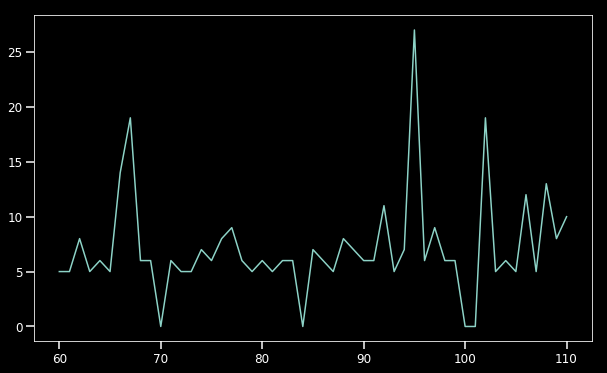

In [9]:
plt.plot(runs, fails)
plt.show()